In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplt_style_n
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

import scipy
import shapely

In [2]:
from WaterQuality_project import report_functions as rf

### 1) Use the functions for this project

In [3]:
# if working on Colab:
#!pip install git+https://github.com/lonanni/InnovationProject_WaterQuality; #build env from here
#from WaterQuality_project import report_functions as rf


In [4]:
from WaterQuality_project import report_functions as rf

### 2) Loading the dataframe

In [5]:
data_dir = "./data"
region_code = "SSD" #change it for the region code of your region of interest
# Load the dataset as build in Build_WaterQualityDataset
df = pd.read_csv(data_dir+'/'+region_code+'WaterQualityData.csv', index_col=False);

### 3) Prepare dataset

In [6]:
processor = rf.WaterQualityProcessor(df)


In [7]:
df = processor.prepare()

In [8]:
from shapely.geometry import Point
import geopandas as gpd
import fiona
from geopandas import GeoDataFrame
from shapely.geometry import Polygon


### 4) UK districts & Macro Region of interest
##### UK districts data available from here https://github.com/icg-innovation/SolentWaterQuality/tree/main/resources

In [9]:
borders_data = data_dir+"/Distribution/"
regions_path = borders_data + "RGN_DEC_2021_EN_BFC.shp"
district_path = borders_data + "Districts.shp"

In [10]:
target_regions = ["South East", "South West"]
region_data = rf.load_selected_regions(regions_path, district_path, target_regions)
regions_ll = region_data["regions_ll"]
regions_en = region_data["regions_en"]

#### 5) Define the ocean in the UK
definition of ocean in the UK

<Axes: >

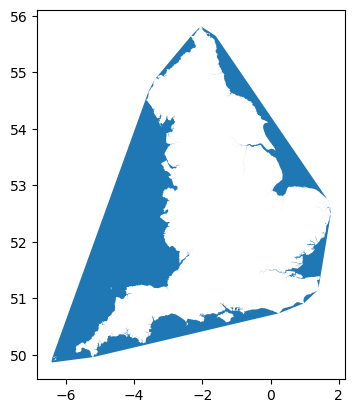

In [11]:
UK_ocean = rf.generate_uk_ocean_boundary(regions_path)
UK_ocean.plot()

### 6) Rivers in the UK
#### river dataset from https://www.ordnancesurvey.co.uk/business-government/products/open-map-rivers

In [12]:
river_dir = data_dir+'/OSrivers/data'
rivers, rivers_course = rf.load_river_data(river_dir)


### 7) Rivers & Districts
#### define the rivers in the area of interest + sampling points by DEFRA in the area

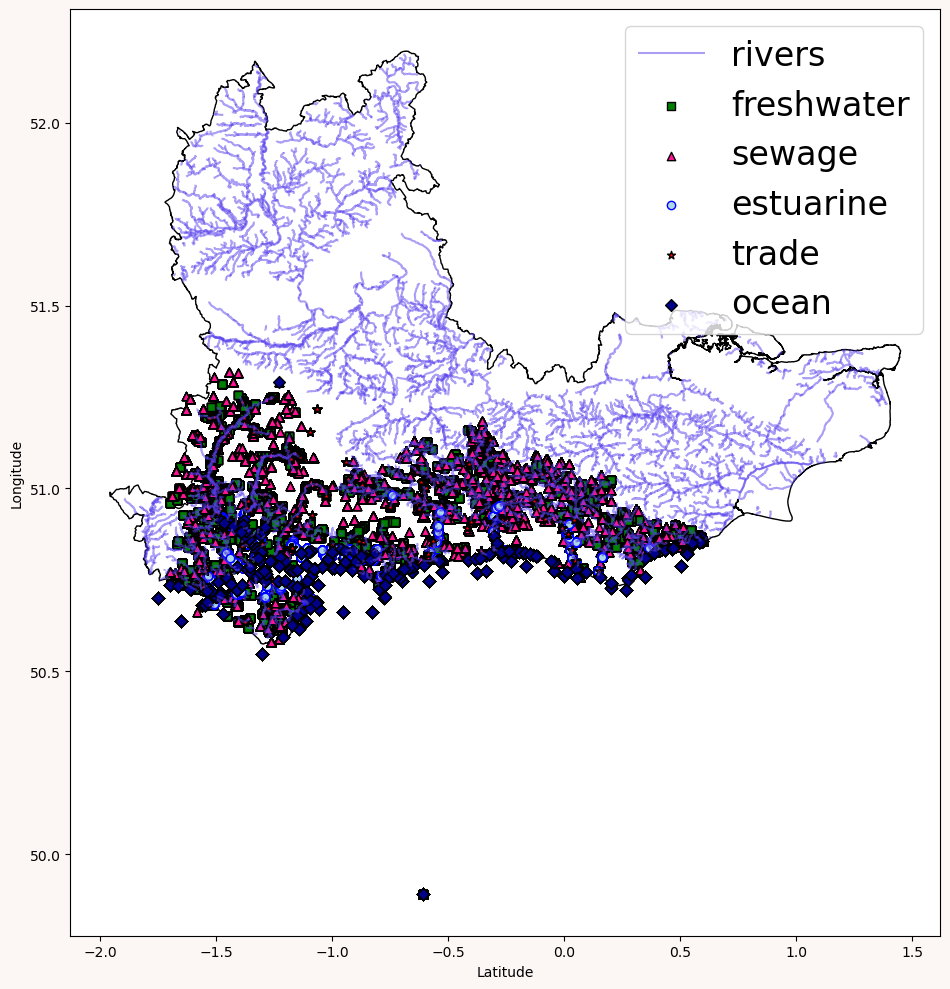

In [15]:
# List of desired labels (ordered as in your original water_names index)
style_by_type = {
    "SEWAGE":     {"color": "deeppink",  "marker": "^", "label": "sewage"},
    "TRADE":     {"color": "red",  "marker": "*", "label": "trade"},
    "ESTUARINE":  {"color": "lightblue", "marker": "o", "edgecolor": "blue", "label": "estuarine"},
    "RIVER":      {"color": "green",     "marker": "s", "label": "freshwater"},
    "OCEAN":      {"color": "darkblue",  "marker": "D", "label": "ocean"},
}
labels = ["RIVER", "SEWAGE", "ESTUARINE", "TRADE", "OCEAN",]
water_names = ['RIVER / RUNNING SURFACE WATER',
 'FINAL SEWAGE EFFLUENT',
 'ESTUARINE WATER',
 'ANY TRADE EFFLUENT', 'SEA WATER']
water_type_map = {label: water_names[i] for i, label in enumerate(labels)}
# Map labels to corresponding water types by index from water_names
river_in_region_of_interest = gpd.sjoin(regions_ll[0], rivers_course, how = 'inner', predicate ='contains')

df_by_type_sub, gdf_by_type_sub = rf.extract_water_type_geodata(df, labels, water_type_map)

rf.plot_water_types_in_region(
    gdf_by_type=gdf_by_type_sub,
    regions_ll=[regions_ll[0]],
    rivers_course=rivers_course,
    river_index=river_in_region_of_interest.index_right,
    style_by_type=style_by_type,
    figsize=(10,10)
)

### 8) Selecting Locations in Postcodes of interest

In [16]:
postcode_numbers = np.concatenate([range(13), range(33, 36)])
postcode_of_interest = "PO"
uk_district = gpd.read_file(district_path)

In [17]:
district_of_interest, gdf_loc_all, locations_of_interest = rf.get_sample_locations_by_postcode(
    df,
    uk_district,
    postcode_prefix=postcode_of_interest,
    postcode_numbers=postcode_numbers
)

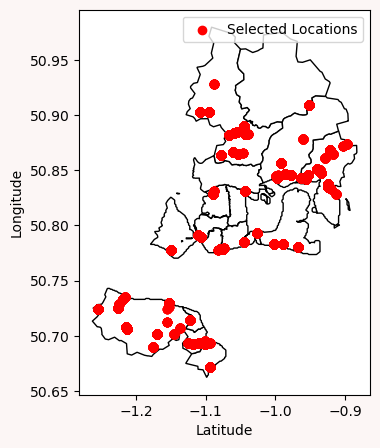

In [18]:
rf.plot_selected_locations(district_of_interest, locations_of_interest)

### 9) Building the polygon containing all the locations

In [19]:
# Select points of interest from all locations using the index values
point_of_interest = gdf_loc_all.iloc[locations_of_interest.index.values]

# Build convex hull polygon
polygon = rf.build_convex_hull_polygon(point_of_interest)


 ### 10) points and rivers in the polygon

In [20]:
polygon_results = rf.get_data_within_polygon(
    polygon=polygon,
    rivers=rivers,
    rivers_course=rivers_course,
    UK_ocean=UK_ocean,
    gdf_loc_all=gdf_loc_all,
    df=df,
    labels=labels,
    water_type_map=water_type_map
)


In [21]:
mask_location = polygon_results["mask_location"]
mask_location_course = polygon_results["mask_location_course"]
df_of_interest = polygon_results["df_of_interest"]
gdf_by_type_sub = polygon_results["gdf_by_type_sub"]
sea = polygon_results["sea"]

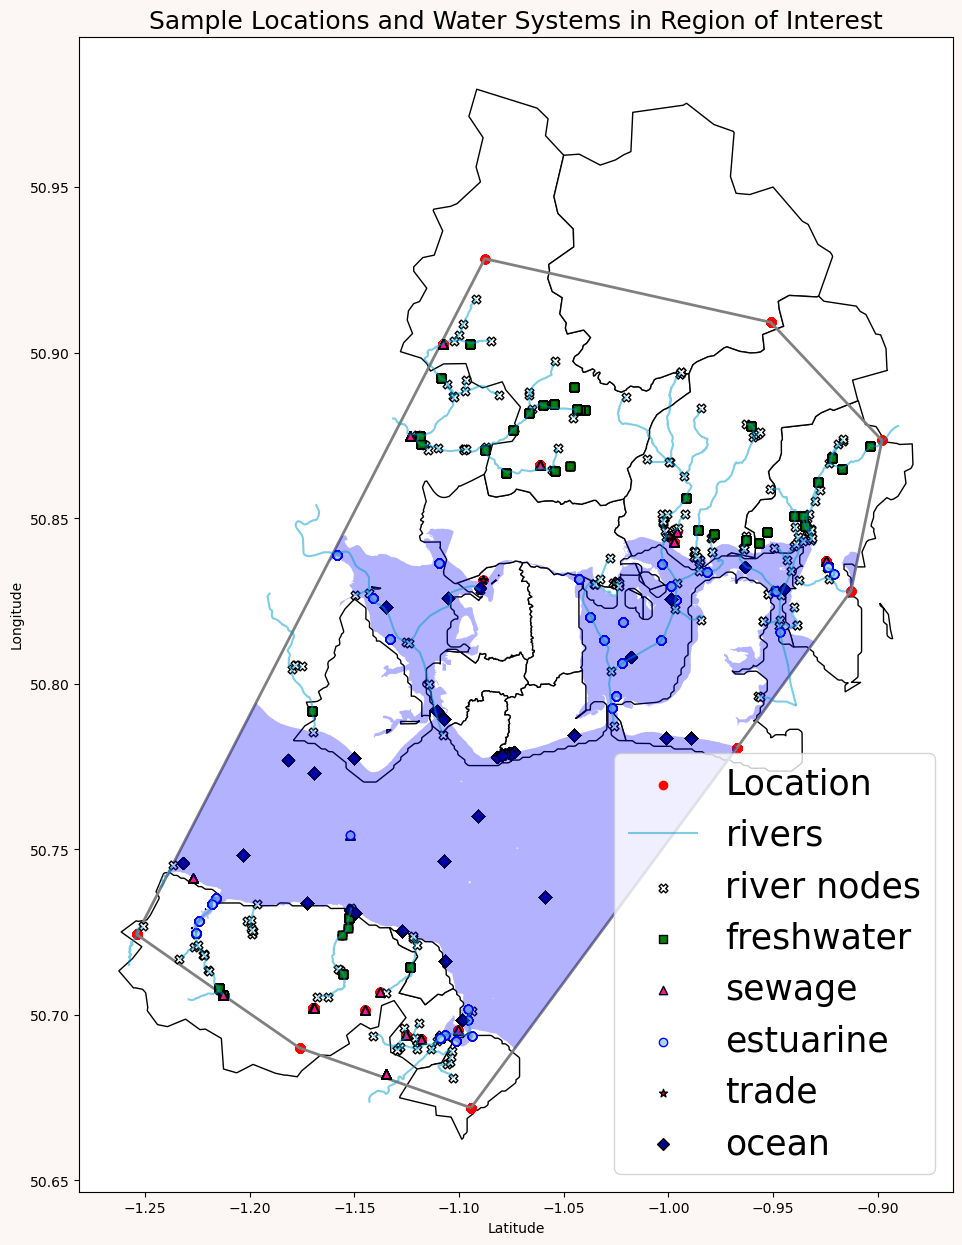

In [22]:
rf.plot_polygon_context(
    district_of_interest=district_of_interest,
    gdf_loc_all=gdf_loc_all,
    locations_of_interest=locations_of_interest,
    polygon=polygon,
    rivers=rivers,
    rivers_course=rivers_course,
    mask_location=polygon_results["mask_location"],
    mask_location_course=polygon_results["mask_location_course"],
    gdf_by_type_sub=polygon_results["gdf_by_type_sub"],
    sea=polygon_results["sea"],
    style_by_type=style_by_type
)

### 11) Buffer on the points to associate locations with water systems

In [23]:
buffer_results = rf.build_buffers_and_perform_join(
    df_of_interest=df_of_interest,
    rivers_course=rivers_course,
    mask_location_course=mask_location_course,
    sea=sea
)

In [24]:
gdf_location_studied = buffer_results["gdf_location_studied"]
gdf_location_studied_buff = buffer_results["gdf_location_studied_buff"]
gdf_water = buffer_results["gdf_water"]
gdf_water_buff = buffer_results["gdf_water_buff"]
united_water = buffer_results["united_water"]
join_rivers = buffer_results["join_rivers"]

#### 12) ASSOCIATE POINTS TO THE DIFFERENT WATER SYSTEM

In [25]:
united_water_course = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf_water_buff.unary_union)).explode()


/var/folders/3r/rtlnqdhs2252wkq2f4bdx2fc0000gn/T/ipykernel_53754/1417532437.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  united_water_course = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf_water_buff.unary_union)).explode()


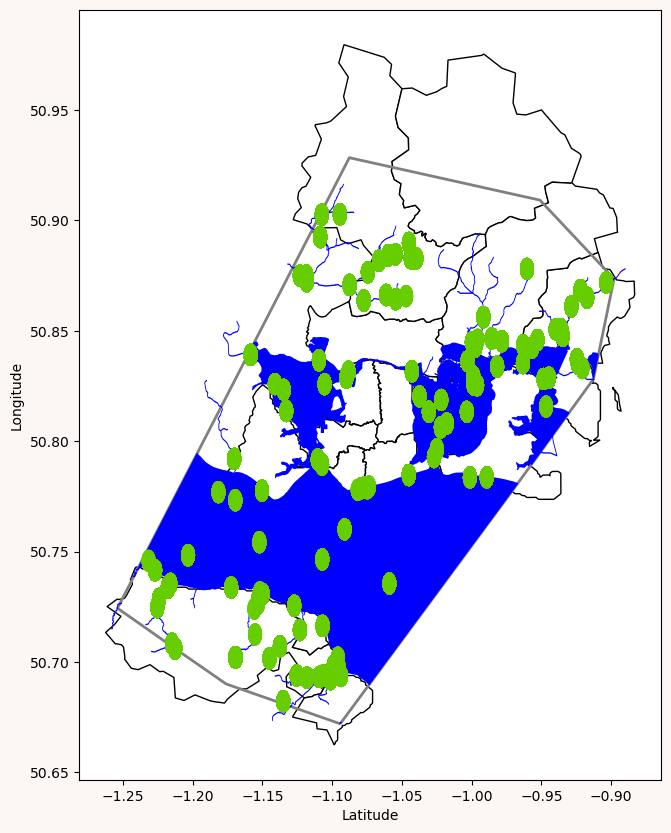

In [26]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)

district_of_interest.plot(ax=ax, color='white', edgecolor='black')
polygon.plot(ax = ax, color='None', edgecolor='grey', linewidth=2)
united_water_course.plot(ax = ax, color='blue', markersize=10, alpha=1, label="rivers")

gdf_location_studied_buff.plot(ax=ax, color='#66CD00', markersize=40, marker="s", label="locations")


ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

### 12) Selecting the points in one of the river system

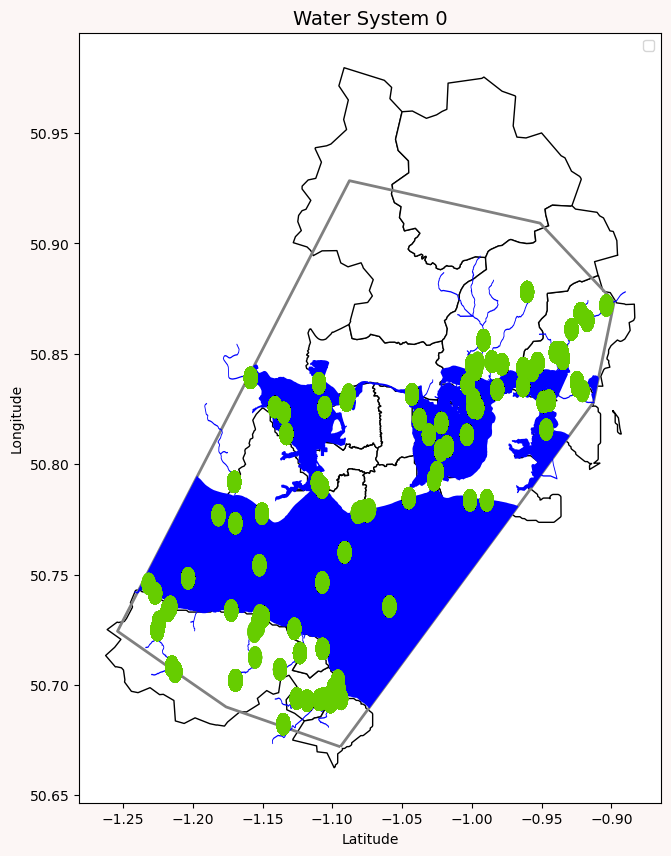

Skipping system 1: no data.
Skipping system 2: no data.
Skipping system 3: no data.


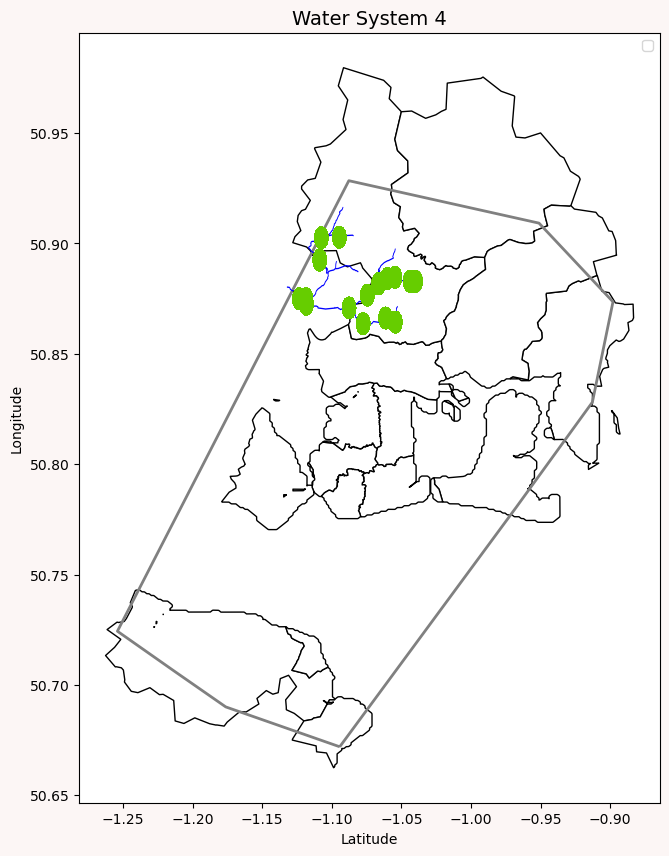

Skipping system 5: no data.
Skipping system 6: no data.
Skipping system 7: no data.
Skipping system 8: no data.
Skipping system 9: no data.
Skipping system 10: no data.
Skipping system 11: no data.
Skipping system 12: no data.
Skipping system 13: no data.
Skipping system 14: no data.
Skipping system 15: no data.
Skipping system 16: no data.
Skipping system 17: no data.
Skipping system 18: no data.
Skipping system 19: no data.


In [27]:
rf.plot_water_system_locations(
    district_gdf=district_of_interest,
    polygon_gdf=polygon,
    united_water_gdf=united_water,
    sample_gdf=gdf_location_studied_buff,
    join_df=join_rivers,
    systems_to_plot= np.arange(0,20) 
)

In [28]:
# Extract samples grouped by system
samples_by_system = rf.extract_samples_by_water_system(df_of_interest, join_rivers)


In [29]:
samples_by_system

{0:         sample.sampleDateTime  sample.samplingPoint.easting  \
 909       2000-01-06T11:00:00                        455290   
 910       2000-01-06T11:00:00                        455290   
 911       2000-01-06T11:00:00                        455290   
 912       2000-01-06T11:00:00                        455290   
 913       2000-01-06T11:00:00                        455290   
 ...                       ...                           ...   
 1619942   2025-06-09T13:16:00                        463755   
 1619943   2025-06-09T13:38:00                        463150   
 1619949   2025-06-09T14:05:00                        460100   
 1620081   2025-06-14T10:21:00                        463090   
 1620082   2025-06-14T10:21:00                        463090   
 
          sample.samplingPoint.northing sample.sampledMaterialType.label  \
 909                              92950                  ESTUARINE WATER   
 910                              92950                  ESTUARINE WATER   